In [1]:
# Import common GIS tools
import numpy as np

from tqdm.keras import TqdmCallback

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from myFunction import *

In [2]:
# Import data
X = np.load("data/rvi.npy")
t = np.load("data/times.npy")
y = np.load("data/y.npy")

# Interpolation of RVI value into evenly spaced time points
X = interpol_X(X, t)

In [3]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# Reshape the data from (x, y) into (x, y, 1). Needed to use Conv1D layers
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [4]:
# Shuffle row
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

idx = np.random.permutation(len(x_val))
x_val = x_val[idx]
y_val = y_val[idx]

In [5]:
# Create the model
model = make_model(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           512       
                                                                 
 batch_normalization (BatchN  (None, 100, 64)          256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           20544     
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 64)           12352 

In [6]:
# Train the model
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"), # Save the best model based on val_loss
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001), # Reduce lr if val_loss don't change
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1), # Stop to train if val_loss don't change
    TqdmCallback(verbose=1) # Progress bar
]

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_val, y_val),
    verbose=0,
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 408: early stopping


In [7]:
model = keras.models.load_model("best_model.h5")

print("Train loss and accuracy")
test_loss, test_acc = model.evaluate(x_train, y_train)
print("Val loss and accuracy")
test_loss, test_acc = model.evaluate(x_val, y_val)
print("Test loss and accuracy")
test_loss, test_acc = model.evaluate(x_test, y_test)

Train loss and accuracy
12/12 [==============================] - 0s 4ms/step - loss: 8.0625e-05 - accuracy: 1.0000
Val loss and accuracy
3/3 [==============================] - 0s 4ms/step - loss: 6.7971e-05 - accuracy: 1.0000
Test loss and accuracy
4/4 [==============================] - 0s 4ms/step - loss: 2.6212e-05 - accuracy: 1.0000


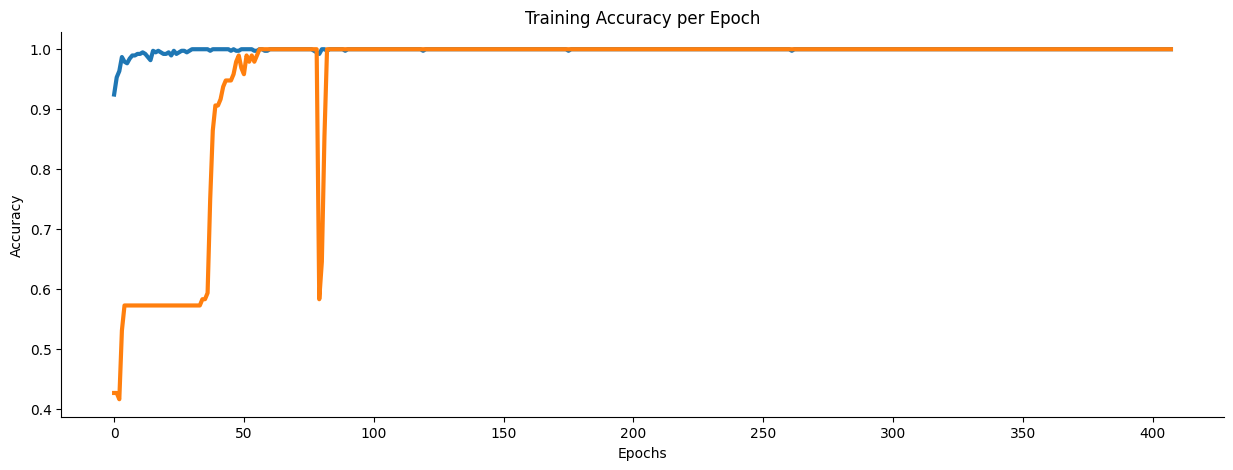

In [8]:
plot_accuracy(history)

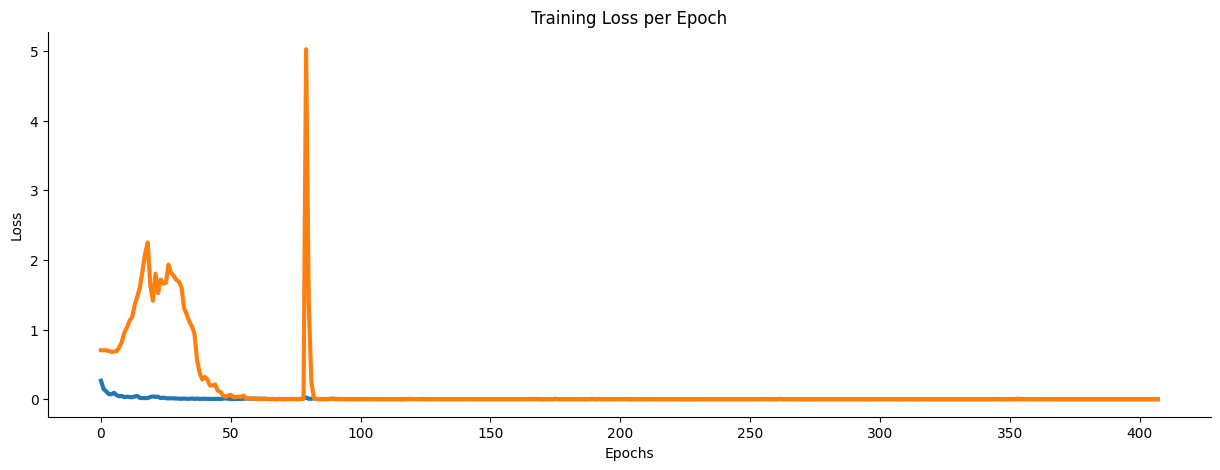

In [9]:
plot_loss(history)